In [1]:
import numpy as np
import scipy.signal as sig
import scipy.io
import os
import librosa
import sys
from IPython.display import display, Audio
import time

import matplotlib.pyplot as plt
plt.rc('text', usetex=True)
plt.rc('font', size=10)
plt.rc('font', family='serif')
plt.rc('lines', linewidth = .5)
cm = 2.54
# setting path
sys.path.append("../")
from Utils.dB import *
#from HN_decomposition.Subspace import *
from HN_decomposition.Subspace.preprocessing_numpy import *
from HN_decomposition.Subspace.ESPRIT_numpy import *

def RMS(x):
        return np.std(x)

figsize = (8.5/cm, 6/cm)

def normalize(input_array, value = 1):
        return input_array/np.amax(np.abs(input_array))*value

In [2]:
## Base params

dpi = 300
cmap = 'gray_r'

## ESTER Criterion

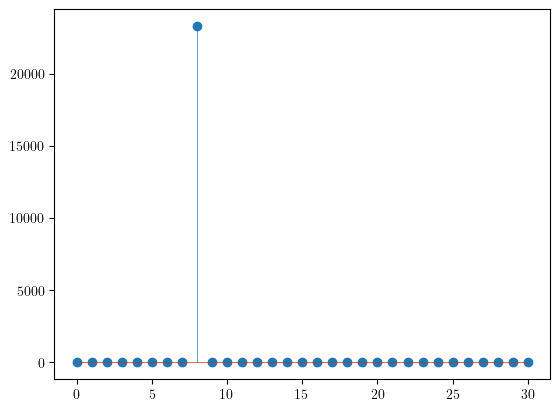

In [3]:
amps_nus = [[1, .1], [1, .2], [1, .4], [.9, .04]]

amp_noise = .1
length_smp = 512

x = np.zeros(length_smp, dtype= np.complex128)

for amp_nu in amps_nus:
    amp = amp_nu[0]
    nu = amp_nu[1]
    x += amp*np.sin(2*np.pi*nu*np.arange(length_smp))

x += amp_noise*np.random.randn(length_smp)


_, J_list = ESTER(
    x=x,
    start_idx = 15,
    window_length = 256,
    max_poles = 30,
    factor = 10
)

plt.stem(J_list)
plt.show()

## Loading the audio file

..\Data\Mesures\Mesures_2023.01.27_LAM\Medium_1\Corde_Acier\C_3_P_3_1.mat
dict_keys(['__header__', '__version__', '__globals__', 'FRF', 'acc_t', 'fen_acc', 'fen_mar', 'freq', 'fs', 'mar_t', 'None', 'signal_accelero_fen', 'signal_marteau_fen', 'time', '__function_workspace__'])
sample rate : 51200 Hz


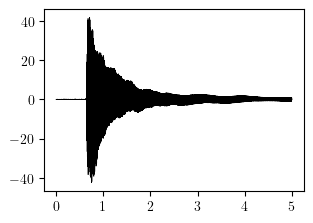

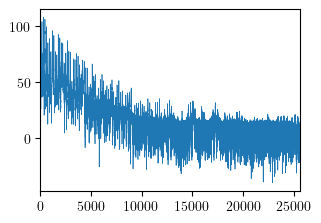

In [4]:
start_sec = .82
length_sec = 4

start_sec = 0
length_sec = 5

fileName = os.path.join('..', 'Data', 'Mesures', 'Mesures_2023.01.27_LAM', 'Medium_1', 'Corde_Acier', 'C_3_P_3_1.mat')
print(fileName)
data = scipy.io.loadmat(fileName)
print(data.keys())

sr_hz_old =  data['fs'][0,0]
x = data['acc_t'][int(sr_hz_old*start_sec):int(sr_hz_old*(start_sec+length_sec)),0].T
t = np.arange(len(x))/sr_hz_old

print(f'sample rate : {sr_hz_old} Hz')

plt.figure(figsize = figsize)
plt.plot(t,x,'k', linewidth = .5)
plt.show()

plt.figure(figsize = figsize)
plt.plot(np.fft.rfftfreq(len(x), 1/sr_hz_old), dB20(np.fft.rfft(x)))
#plt.semilogx()
plt.xlim(0, sr_hz_old/2)
plt.show()

## Resampling

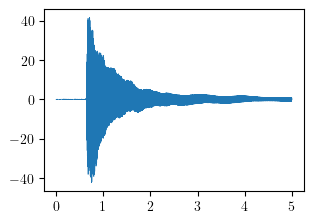

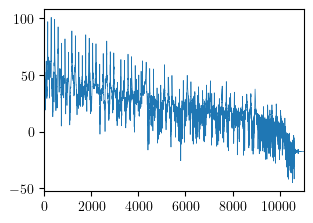

In [5]:
sr_hz = 22050
x = librosa.resample(x, orig_sr = sr_hz_old, target_sr = sr_hz)
t = np.arange(len(x))/sr_hz
plt.figure(figsize = figsize)
plt.plot(t,x)
plt.show()
plt.figure(figsize = figsize)
plt.plot(np.fft.rfftfreq(len(x), 1/sr_hz), dB20(np.fft.rfft(x)))
plt.xlim(0, sr_hz/2)
plt.show()

In [6]:
save_folder = os.path.join("..", "..", "PAM_overleaf", "Notes", "HR", "Partials_Tracking", "Figures")

## Harmonic+Noise Decomposition

6


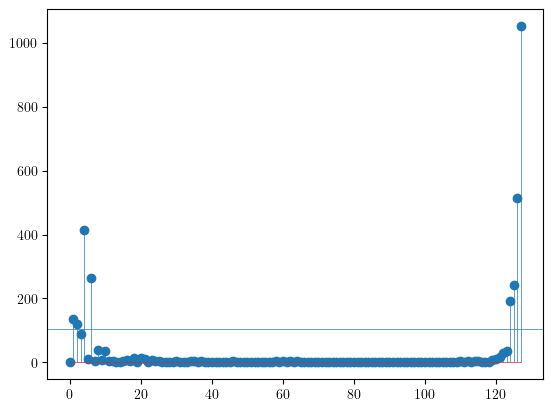

In [7]:
start_idx = np.argmax(np.abs(sig.hilbert(x)))
factor = 10

## Computations
xWhitened, ARFilter = whiten_signal(
    x = x,
    n_fft = 512,
    rankFilter_bins = 100,
    rankFilter_rank = .3,
    ARFilter_length = 12,
)

num_poles, J_list = ESTER(
    x = xWhitened,
    start_idx=start_idx,
    window_length=256,
    max_poles = 127,
    factor = factor
)

print(num_poles)
plt.stem(J_list)
plt.axhline(np.amax(J_list)/factor)
plt.show()

Overlap add condition : True
num_poles 26


c:\Users\pelad\AppData\Local\Programs\Python\Python310\lib\site-packages\IPython\lib\display.py:172: ComplexWarning: Casting complex values to real discards the imaginary part
  data = np.array(data, dtype=float)


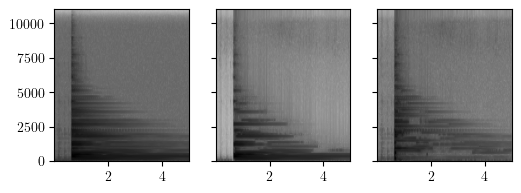

In [8]:
##Parameters
window_length = 512
hop_length = window_length//4

ester_factor = 50
max_poles = 200
window_type = 'hann'

## Checking Overlap Add Condition
#window = sig.get_window(window_type, window_length)
OLA_condition = sig.check_COLA(
    window = window_type,
    nperseg = window_length,
    noverlap = window_length-hop_length
)
print(f"Overlap add condition : {OLA_condition}")

## Computations
xWhitened, ARFilter = whiten_signal(
    x = x,
    n_fft = 512,
    rankFilter_bins = 100,
    rankFilter_rank = .3,
    ARFilter_length = 12,
)

num_poles, _ = ESTER(
    x = x,
    start_idx=start_idx,
    window_length=window_length,
    max_poles = max_poles,
    factor = ester_factor
)
print(f'num_poles {num_poles}')


xChoppedWhitened = window_signal(
    x = xWhitened,
    window_length = window_length,
    hop_length = hop_length
)

xChopped = window_signal(
    x = x,
    window_length = window_length,
    hop_length = hop_length
)

xHarmo, xNoise = HN_ESPRIT(
    xChoppedWhitened = xChoppedWhitened,
    num_poles = num_poles,
    xChopped = xChopped,
    hop_length = hop_length,
    window_type = window_type)

display(Audio(data = x, rate = sr_hz))
display(Audio(data = xHarmo, rate = sr_hz))
display(Audio(data = xNoise, rate = sr_hz))

fig, ax = plt.subplots(nrows= 1, ncols = 3, sharey = True, figsize = (15/cm, 5/cm))
ax[0].specgram(x, Fs = sr_hz, cmap = cmap)
ax[1].specgram(np.real(xHarmo), Fs = sr_hz, cmap = cmap)
ax[2].specgram(np.real(xNoise), Fs = sr_hz, cmap = cmap)
plt.show()

Overlap add condition : True
Signal Order : 62
Processing time : 8.63s


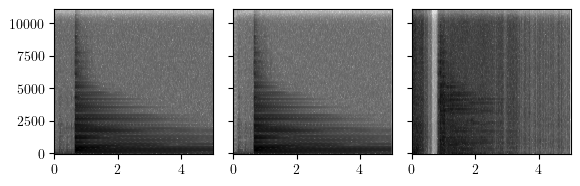

In [9]:
##Parameters
window_length = 512
hop_length = window_length//8
window_type = 'hann'
beta = .95

ester_factor = 50
max_poles = 200
## Checking Overlap Add Condition
#window = sig.get_window(window_type, window_length)
OLA_condition = sig.check_COLA(
    window = window_type,
    nperseg = window_length,
    noverlap = window_length-hop_length
)
print(f"Overlap add condition : {OLA_condition}")
##Computations

tic = time.time()
xWhitened, ARFilter = whiten_signal(
    x = x,
    n_fft = 512,
    rankFilter_bins = 100,
    rankFilter_rank = .3,
    ARFilter_length = 12,
)
start_idx = np.argmax(np.abs(sig.hilbert(x)))

num_poles, _ = ESTER(
    x = xWhitened,
    start_idx=start_idx,
    window_length=window_length,
    max_poles = max_poles,
    factor = ester_factor
)

print(f'Signal Order : {num_poles}')
xChoppedWhitened = window_signal(
    x = x,
    window_length = window_length,
    hop_length = hop_length
)

xChopped = window_signal(
    x = x,
    window_length = window_length,
    hop_length = hop_length
)

xHarmo, xNoise = HN_FAPI(
    xChoppedWhitened = xChoppedWhitened,
    num_poles = num_poles,
    beta=beta,
    xChopped = xChopped,
    hop_length = hop_length,
    window_type = window_type)
toc = time.time()

print(f'Processing time : {round(toc-tic, 2)}s')

display(Audio(data = x, rate = sr_hz))
display(Audio(data = np.real(xHarmo), rate = sr_hz))
display(Audio(data = np.real(xNoise[sr_hz//5:]), rate = sr_hz))

fig, ax = plt.subplots(nrows= 1, ncols = 3, sharey = True, figsize = (15/cm, 5/cm))

f, t, x_stft = sig.stft(np.real(x), fs = sr_hz, return_onesided=True, scaling = 'psd')
ax[0].pcolormesh(t, f, dB10(x_stft), cmap = cmap, rasterized = True)
f, t, x_stft = sig.stft(np.real(xHarmo), fs = sr_hz, return_onesided=True, scaling = 'psd')
ax[1].pcolormesh(t, f, dB10(x_stft), cmap = cmap, rasterized = True)
f, t, x_stft = sig.stft(np.real(xNoise), fs = sr_hz, return_onesided=True, scaling = 'psd')
ax[2].pcolormesh(t, f, dB10(x_stft), cmap = cmap, rasterized = True)
plt.tight_layout()
plt.show()
